* Explore proper fitting methods to the noisy and gappy time series over Thai Binh
* Evaluate the fitting results againt the field data of cropy yield

In [1]:
import os
import sys
import itertools
import glob

import numpy as np
import pandas as pd
from osgeo import gdal, gdal_array, osr, ogr

import scipy as sp
from scipy import odr as spodr
import uncertainties as unc

import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import axes_grid1

import seaborn as sns

In [2]:
sns.set_context("paper")
sns.set_style("whitegrid")
dpi = 300

In [3]:
import plotly.plotly as pply
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=False) # run at the start of every ipython notebook to use plotly.offline
                     # this injects the plotly.js source files into the notebook
import plotly.tools

In [4]:
import geo_ts as gt

In [5]:
# input csv file name
var_names = ['ndvi', 'evi', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2']
csv_files = ['../results/thai_binh_field_subp_ts_{0:s}_fuse_at.csv'.format(varn) for varn in var_names]

csvf_ts_ndvi_sg = '../results/thai_binh_field_subp_ts_ndvi_sg.csv'
csvf_ts_ndvi_fuse_terra = '../results/thai_binh_field_subp_ts_ndvi_fuse_terra.csv'

csvf_ts_alos_hh = '../results/thai_binh_field_subp_ts_alos_hh.csv'
csvf_ts_alos_hv = '../results/thai_binh_field_subp_ts_alos_hv.csv'

In [6]:
ts_data_list = [pd.read_csv(csvf, header=[0, 1], index_col=0).sort_index().sort_index(axis=1) for csvf in csv_files]
ts_ndvi_fuse_aq = ts_data_list[0]
ts_evi_fuse_aq = ts_data_list[1]

ts_ndvi_sg = pd.read_csv(csvf_ts_ndvi_sg, header=[0, 1], index_col=0).sort_index().sort_index(axis=1)
ts_ndvi_sg.columns = ts_ndvi_sg.columns.droplevel('type').astype(int)
ts_ndvi_sg = ts_ndvi_sg.sort_index(axis=1)

ts_ndvi_fuse_terra = pd.read_csv(csvf_ts_ndvi_fuse_terra, header=[0, 1], index_col=0).sort_index().sort_index(axis=1)
ts_ndvi_fuse_terra.columns = ts_ndvi_fuse_terra.columns.droplevel('type').astype(int)
ts_ndvi_fuse_terra = ts_ndvi_fuse_terra.sort_index(axis=1)

ts_alos_hh = pd.read_csv(csvf_ts_alos_hh, header=0, index_col=0).sort_index().sort_index(axis=1)
ts_alos_hh.columns = ts_alos_hh.columns.astype(int)
ts_alos_hh = ts_alos_hh.sort_index(axis=1)

ts_alos_hv = pd.read_csv(csvf_ts_alos_hv, header=0, index_col=0).sort_index().sort_index(axis=1)
ts_alos_hv.columns = ts_alos_hv.columns.astype(int)
ts_alos_hv = ts_alos_hv.sort_index(axis=1)

In [7]:
no_data = -9999

## Calculate GCVI

In [8]:
invalid_flag = (ts_data_list[5] == no_data) | (ts_data_list[3] == no_data)

ts_gcvi = ts_data_list[5]/ts_data_list[3] - 1

ts_gcvi[invalid_flag] = no_data

In [9]:
ts_ndvi_fuse_terra[ts_ndvi_fuse_terra<=0.1] = no_data
ts_ndvi_sg[ts_ndvi_sg<=0.1] = no_data
ts_ndvi_fuse_aq[ts_ndvi_fuse_aq<=0.1] = no_data
ts_evi_fuse_aq[ts_evi_fuse_aq<=0.1] = no_data

## Merge fusion and actual observation

In [10]:
def mergeFuseObs(ts_data):
    uniq_doy, cnt = np.unique(ts_data.columns.droplevel('type').values, return_counts=True)
    merge_arr = np.zeros((len(ts_data), len(uniq_doy))) + no_data
    merge_arr = pd.DataFrame(merge_arr, columns=uniq_doy, index=ts_data.index)
    for col, n in zip(uniq_doy, cnt):
        if n>1:
            tmp = [ts_data.loc[ind, ('obs', col)] if ts_data.loc[ind, ('obs', col)]!=no_data else ts_data.loc[ind, ('fuse', col)] for ind in merge_arr.index]
            merge_arr.loc[:, col] = tmp
        else:
            merge_arr.loc[:, col] = ts_data.loc[:, ('obs', col)] if ('obs', col) in ts_data.columns else ts_data.loc[:, ('fuse', col)]
    return merge_arr    

In [11]:
ts_ndvi_fuse_aq_merge = mergeFuseObs(ts_ndvi_fuse_aq)
ts_evi_fuse_aq_merge = mergeFuseObs(ts_evi_fuse_aq)

ts_gcvi_merge = mergeFuseObs(ts_gcvi)

In [12]:
ts_ndvi_fuse_aq_merge.columns = ts_ndvi_fuse_aq_merge.columns.astype(int)
ts_ndvi_fuse_aq_merge = ts_ndvi_fuse_aq_merge.sort_index(axis=1)

ts_evi_fuse_aq_merge.columns = ts_evi_fuse_aq_merge.columns.astype(int)
ts_evi_fuse_aq_merge = ts_evi_fuse_aq_merge.sort_index(axis=1)

ts_gcvi_merge.columns = ts_gcvi_merge.columns.astype(int)
ts_gcvi_merge = ts_gcvi_merge.sort_index(axis=1)

## Read field data of crop yield

In [13]:
crop_yield_field_file = "/projectnb/echidna/lidar/zhanli86/workspace/data/projects/kaiyu-adb-crop/vietnam-field/Thai_Binh_select_variables_crop_cutting.xlsx"
cls_map_file = "/projectnb/echidna/lidar/zhanli86/workspace/data/projects/kaiyu-adb-crop/vietnam-cls/vietnam_thai_bin_cls_rf_lsat_scenes.img"

crop_yield_field = pd.read_excel(crop_yield_field_file, sheetname=0, \
                                 index_col=2)

colname = crop_yield_field.columns.values
colname[2] = "lat_m" # mesh lat
colname[3] = "lon_m" # mesh lon
colname[4] = "lat_s" # subplot lat
colname[5] = "lon_s" # subplot lon
colname[7] = "yield_field" # field measured yield
crop_yield_field.columns = colname

geo_points = pd.DataFrame(np.zeros((len(crop_yield_field), 2)), index=crop_yield_field.index, columns=['lon', 'lat'])
geo_points.loc[:, 'lat'] = crop_yield_field.loc[:, 'lat_s']
geo_points.loc[:, 'lon'] = crop_yield_field.loc[:, 'lon_s']

proj_points = pd.DataFrame(np.zeros((len(geo_points), 2)), index=geo_points.index, columns=['x', 'y'])
for k in proj_points.index:
    tmp = gt.geo2Proj(cls_map_file, geo_points.loc[k, 'lon'], geo_points.loc[k, 'lat'])
    proj_points.loc[k, 'x'] = tmp[0]
    proj_points.loc[k, 'y'] = tmp[1]
    
img_points = pd.DataFrame(np.zeros((len(geo_points), 2)), index=geo_points.index, columns=['sample', 'line'])
for k in img_points.index:
    tmp = gt.geo2Pixel(cls_map_file, geo_points.loc[k, 'lon'], geo_points.loc[k, 'lat'], ret_int=False)
    img_points.loc[k, 'sample'] = tmp[0]
    img_points.loc[k, 'line'] = tmp[1]

subp_imgsize = 2.5/30
img_points_ur = img_points.copy()
img_points_ur.loc[:, 'sample'] = (img_points.loc[:, 'sample']+subp_imgsize).astype(int)
img_points_ur.loc[:, 'line'] = (img_points.loc[:, 'line']-subp_imgsize).astype(int)

img_points_ll = img_points.copy()
img_points_ll.loc[:, 'sample'] = img_points.loc[:, 'sample'].astype(int)
img_points_ll.loc[:, 'line'] = img_points.loc[:, 'line'].astype(int)

img_points_ul = img_points.copy()
img_points_ul.loc[:, 'sample'] = (img_points.loc[:, 'sample']).astype(int)
img_points_ul.loc[:, 'line'] = (img_points.loc[:, 'line']-subp_imgsize).astype(int)

img_points_lr = img_points.copy()
img_points_lr.loc[:, 'sample'] = (img_points.loc[:, 'sample']+subp_imgsize).astype(int)
img_points_lr.loc[:, 'line'] = (img_points.loc[:, 'line']).astype(int)

img_points_ctr = img_points.copy()
img_points_ctr.loc[:, 'sample'] = (img_points.loc[:, 'sample']+0.5*subp_imgsize).astype(int)
img_points_ctr.loc[:, 'line'] = (img_points.loc[:, 'line']-0.5*subp_imgsize).astype(int)

## Read classification map

In [14]:
from classify_image import ImageClassifier

In [15]:
ic = ImageClassifier()
cls_map = ic.readRaster(cls_map_file)[0][0]

cls_map_profile = gt.getRasterMetaGdal(cls_map_file)

## Select field subplots falling into our image extent

In [16]:
cls_map_meta = gt.getRasterMetaGdal(cls_map_file)

ncols = cls_map_meta['RasterXSize']
nrows = cls_map_meta['RasterYSize']

in_subp_flag = reduce(np.logical_and, (img_points_ur.loc[:, 'sample']>=0, img_points_ur.loc[:, 'sample']<ncols, \
                                       img_points_ur.loc[:, 'line']>=0, img_points_ur.loc[:, 'line']<nrows, \
                                       img_points_ll.loc[:, 'sample']>=0, img_points_ll.loc[:, 'sample']<ncols, \
                                       img_points_ll.loc[:, 'line']>=0, img_points_ll.loc[:, 'line']<nrows))
print crop_yield_field.loc[np.logical_not(in_subp_flag), :]

crop_yield_field = crop_yield_field.loc[in_subp_flag, :]

geo_points = geo_points.loc[in_subp_flag, :]
proj_points = proj_points.loc[in_subp_flag, :]
img_points = img_points.loc[in_subp_flag, :]
img_points_ur = img_points_ur.loc[in_subp_flag, :]
img_points_ll = img_points_ll.loc[in_subp_flag, :]
img_points_ul = img_points_ur.loc[in_subp_flag, :]
img_points_lr = img_points_ll.loc[in_subp_flag, :]
img_points_ctr = img_points_ctr.loc[in_subp_flag, :]

single_pix_subp_flag = np.logical_and(img_points_ur.loc[:, 'sample']==img_points_ll.loc[:, 'sample'], \
                                      img_points_ur.loc[:, 'line']==img_points_ll.loc[:, 'line'])

            mesh_id plot_id     lat_m      lon_m      lat_s  lon_s variety  \
full_id                                                                      
017850-p10    17850     p10  20.62202  106.37985  20.621892    106    BC15   

            yield_field  
full_id                  
017850-p10  3609.709322  


In [17]:
# get the geolocation of subplot center
geo_points_ctr = pd.DataFrame(np.zeros((len(img_points_ctr), 2)), index=img_points_ctr.index, columns=['lon', 'lat'])
for k in geo_points_ctr.index:
    tmp = gt.pixel2Geo(cls_map_file, img_points_ctr.loc[k, 'sample'], img_points_ctr.loc[k, 'line'])
    geo_points_ctr.loc[k, 'lon'] = tmp[0]
    geo_points_ctr.loc[k, 'lat'] = tmp[1]
    
# get the projection coordinates of subplot centers
proj_points_ctr = pd.DataFrame(np.zeros((len(img_points_ctr), 2)), index=img_points_ctr.index, columns=['x', 'y'])
for k in proj_points_ctr.index:
    tmp = gt.pixel2Proj(cls_map_profile['GeoTransform'], img_points_ctr.loc[k, 'sample'], img_points_ctr.loc[k, 'line'])
    proj_points_ctr.loc[k, 'x'] = tmp[0]
    proj_points_ctr.loc[k, 'y'] = tmp[1]

## Determine a buffer zone of pure crop pixels

In [18]:
# Select subplots with four corners all in crop class pixels

cond_list = [cls_map[img_points_ctr.loc[:, 'line']+line_shift, img_points_ctr.loc[:, 'sample']+sample_shift]==1 \
             for line_shift in (-1, 0, 1) for sample_shift in (-1, 0, 1)]

crop_pix_flag = reduce(np.logical_and, cond_list)
single_crop_pix_flag = cls_map[img_points_ctr.loc[:, 'line'], img_points_ctr.loc[:, 'sample']]==1

In [19]:
print len(crop_pix_flag)
print np.sum(crop_pix_flag)
print np.sum(single_crop_pix_flag)
print len(crop_pix_flag) - np.sum(single_crop_pix_flag)

255
134
220
35


In [20]:
img_points = pd.DataFrame(np.zeros((len(geo_points), 2)), index=geo_points.index, columns=['sample', 'line'])
for k in img_points.index:
    tmp = gt.geo2Pixel(cls_map_file, geo_points.loc[k, 'lon'], geo_points.loc[k, 'lat'], ret_int=False)
    img_points.loc[k, 'sample'] = tmp[0]
    img_points.loc[k, 'line'] = tmp[1]

In [21]:
pix_frac_thresh = 0.4

In [22]:
tmp_flag = np.logical_and((np.ceil(img_points) - img_points)>pix_frac_thresh, (img_points-np.floor(img_points))>pix_frac_thresh)
pix_frac_flag = tmp_flag.all(axis=1)

## Output field subplots and selected ones to shape files

In [23]:
field_subp_shp = '../results/thai_binh_crop_field_subp.shp'
if os.path.isfile(field_subp_shp):
    os.remove(field_subp_shp)

In [24]:
# set up the shapefile driver
driver = ogr.GetDriverByName("ESRI Shapefile")

# create the data source
data_source = driver.CreateDataSource(field_subp_shp)

# create the spatial reference, WGS84
srs = osr.SpatialReference()
srs.ImportFromWkt(cls_map_profile['ProjectionRef'])

layer = data_source.CreateLayer("field_subp", srs, ogr.wkbPoint)
# Length of field name cannot be more than 10 characters for ESRI shapefile
field = ogr.FieldDefn("Name", ogr.OFTString)
field.SetWidth(16)
layer.CreateField(field)
layer.CreateField(ogr.FieldDefn("Latitude", ogr.OFTReal))
layer.CreateField(ogr.FieldDefn("Longitude", ogr.OFTReal))
layer.CreateField(ogr.FieldDefn("Sample", ogr.OFTInteger))
layer.CreateField(ogr.FieldDefn("Line", ogr.OFTInteger))
layer.CreateField(ogr.FieldDefn("FieldYield", ogr.OFTReal))
layer.CreateField(ogr.FieldDefn("SelectFlag", ogr.OFTInteger))

# Process the text file and add the attributes and features to the shapefile
for n in range(len(geo_points_ctr)):
    key = geo_points_ctr.index[n]
    # create the feature
    feature = ogr.Feature(layer.GetLayerDefn())
    # Set the attributes
    feature.SetField("Name", "{0:s}".format(key))
    feature.SetField("Latitude", geo_points_ctr.loc[key, 'lat'])
    feature.SetField("Longitude", geo_points_ctr.loc[key, 'lon'])
    feature.SetField("Sample", img_points_ctr.loc[key, 'sample'])
    feature.SetField("Line", img_points_ctr.loc[key, 'line'])
    feature.SetField('FieldYield', crop_yield_field.loc[key, 'yield_field'])
    if crop_pix_flag[n]:
        feature.SetField('SelectFlag', 0)
    elif single_crop_pix_flag[n]:
        feature.SetField('SelectFlag', 1)
    else:
        feature.SetField('SelectFlag', 3)
        
    # create the WKT for the feature using Python string formatting
    wkt = "POINT({0:f} {1:f})".format(float(proj_points_ctr.loc[key, 'x']), float(proj_points_ctr.loc[key, 'y']))

    # Create the point from the Well Known Txt
    point = ogr.CreateGeometryFromWkt(wkt)

    # Set the feature geometry using the point
    feature.SetGeometry(point)
    # Create the feature in the layer (shapefile)
    layer.CreateFeature(feature)
    # Destroy the feature to free resources
    feature.Destroy()

# Destroy the data source to free resources
data_source.Destroy()

## Compare different types of time series

In [25]:
ts_data_compare_list = [ts_ndvi_fuse_aq_merge, ts_evi_fuse_aq_merge]
ts_name_compare_list = ["NDVI A+T", "EVI A+T"]
ts_marker_compare_list = [".b", ".r"]
beg_doy = 225
end_doy = 300

start_ind = 0
select_ind = np.arange(start_ind, start_ind+10, dtype=int)
select_keys = ts_data_compare_list[0].index[select_ind]
# select_ind = np.where(np.in1d(ts_data.index, select_keys))[0]

# for i, k in zip(select_ind, select_keys):
#     fig = plt.figure(figsize=(9, 2.5))
#     ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
#     ax2 = plt.subplot2grid((1, 3), (0, 2), colspan=1)

#     for ti, ts_data in enumerate(ts_data_compare_list):
#         y = ts_data.loc[k, :].copy()
#         x = y.index.values
#         y = y.values
#         tmp_ind = np.where(y != no_data)[0]
#         x = x[tmp_ind]
#         y = y[tmp_ind]
#         ax1.plot(x, y, ts_marker_compare_list[ti], label=ts_name_compare_list[ti])
#         plt.setp(ax1, title=k, xlabel='DOY', ylabel='NDVI')    

#         ts_section = ts_data.loc[k, beg_doy:end_doy].copy()
#         tmp_ind = np.where(ts_section != no_data)[0]
#         y = ts_section.values[tmp_ind]
#         x = ts_section.index.values[tmp_ind]
#         ax2.plot(x, y, ts_marker_compare_list[ti], label=ts_name_compare_list[ti])
#         plt.setp(ax2, title=k, xlabel='DOY')
        
#     ax1.legend()
    
gt.plotTs([ts_data.columns.values for ts_data in ts_data_compare_list], \
    [ts_data.loc[select_keys, :] for ts_data in ts_data_compare_list], \
    geo_points.loc[select_keys, :], \
    fig_kw_dict=dict(figsize=(10, 4)), \
    plot_kw_dict_list=[dict(label="NDVI A+T+Obs", markersize=8), dict(label="EVI A+T+Obs")], \
    ax_kw_dict=dict(ylim=(0, 1.1)), \
    style_list=['.r', '.b'], use_plotly=True, save_fig=False)

In [26]:
# Number of valid NDVI values in each type of time series
ts_data_valid_cnt_list = [np.sum(ts_data!=no_data, axis=1) for ts_data in ts_data_compare_list]

In [27]:
print ts_name_compare_list[0], ts_data_valid_cnt_list[0].head()
print ts_name_compare_list[1], ts_data_valid_cnt_list[1].head()

NDVI A+T full_id
004622-p02    53
004622-p04    54
004622-p08    53
004622-p10    54
011504-p01    49
dtype: int64
EVI A+T full_id
004622-p02    52
004622-p04    53
004622-p08    51
004622-p10    52
011504-p01    48
dtype: int64


## Our tailored temporal fitting
* fit a quadratic curve to a few points around DOY 250 after visual inspection of a lot of time series. 

In [441]:
def quadFunc(x, a, p1, p2):
    return np.poly1d([a, a*p1, a*p2])(x)

# def quadFuncUnc(x, p_nom, p_std):
#     func_list = [lambda p: p[0]*(xv**2)+p[1]*xv+p[2] for xv in x]
#     ufunc_list = [unc.wrap(f) for f in func_list]
#     unc_p = [unc.UFloat(pn, ps) for pn, ps in zip(p_nom, p_std)]
#     import pdb; pdb.set_trace()
#     print unc_p
#     uy = [uf(unc_p) for uf in ufunc_list]
#     y_nom, y_std = zip(*[(uyv.nominal_value, uyv.std_dev) for uyv in uy])
#     return y_nom, y_std

def quadPeakConstrained(ts_data, row_key, beg_doy, end_doy, no_data=-9999, max_iter=100):
    # Read x and y data from the given time series data
    ts_section = ts_data.loc[row_key, beg_doy:end_doy]
    tmp_ind = np.where(ts_section != no_data)[0]
    y0 = ts_section.values[tmp_ind]
    x0 = ts_section.index.values[tmp_ind]
    x = np.copy(x0)
    y = np.copy(y0)
    
    for i in range(max_iter):
        max_y = np.max(y)
        p1_0 = -2*250
        a_0 = -1
        p2_0 = max_y/a_0 - (-0.5*p1_0)**2 - (-0.5*p1_0)*p1_0
        try:
#             popt, pcov = sp.optimize.curve_fit(quadFunc, x, y, 
#                                                p0 = [a_0, p1_0, p2_0], 
#                                                bounds=([-np.inf, -2*(end_doy-10), -np.inf], [0, -2*(beg_doy+10), np.inf]))
            popt, pcov = sp.optimize.curve_fit(quadFunc, x, y, 
                                               p0 = [a_0, p1_0, p2_0], 
                                               bounds=([-np.inf, -2*280, -np.inf], [0, -2*220, np.inf]))
#             popt, pcov = sp.optimize.curve_fit(quadFunc, x, y, 
#                                                p0 = [a_0, p1_0, p2_0], 
#                                                bounds=([-np.inf, -np.inf, -np.inf], [0, np.inf, np.inf]))    
        except RuntimeError as e:
            if str(e).find("Optimal parameters not found: ") == -1:
                raise e
            else:
                peak_x = 0
                peak_y = 0
                peak_y_std = 0
                quad_func = None
                return peak_x, peak_y, peak_y_std, quad_func, max_y
#         print "p estimate", popt
#         print "p covariance", pcov

        # Use the uncertainties package to get the uncertainty of each parameter 
        # from the covariance matrix of the parameter estimates
        unc_p = unc.correlated_values(popt, pcov)
        unc_p = [unc_p[0], unc_p[0]*unc_p[1], unc_p[0]*unc_p[2]]
        
        quad_func = np.poly1d([popt[0], popt[0]*popt[1], popt[0]*popt[2]])
        peak_x = -0.5 * popt[1]
#         peak_y = quad_func(peak_x)
        unc_peak_y = unc_p[0] * (peak_x**2) + unc_p[1] * peak_x + unc_p[2]
        peak_y = unc_peak_y.nominal_value
        peak_y_std = unc_peak_y.std_dev
        
        unc_yfit = unc_p[0] * (x**2) + unc_p[1] * x + unc_p[2]
        yfit_nom, yfit_std = zip(*[(uyv.nominal_value, uyv.std_dev) for uyv in unc_yfit])
        yfit_nom = np.array(yfit_nom)
        yfit_std = np.array(yfit_std)
        # see if the difference between fitted y and measured y is larger than the 3*std_dev
#         tmp_flag = abs(yfit_nom-y) < 2*yfit_std
        tmp_flag = abs(yfit_nom-y) < np.inf
#         tmp_flag = (yfit_nom-y) > -3*yfit_std
        if np.sum(np.logical_not(tmp_flag)) == 0:
            break
        x = x[tmp_flag]
        y = y[tmp_flag]
#         print "finished: {0:d}".format(i)
    
    return peak_x, peak_y, peak_y_std, quad_func, max_y

In [442]:
def quadPeak(ts_data, row_key, beg_doy, end_doy, no_data=-9999, max_iter=100, diff_thresh=1):
    # Read x and y data from the given time series data
    ts_section = ts_data.loc[row_key, beg_doy:end_doy]
    tmp_ind = np.where(ts_section != no_data)[0]
    y0 = ts_section.values[tmp_ind]
    x0 = ts_section.index.values[tmp_ind]    
    x = np.copy(x0)
    y = np.copy(y0)
    
    for i in range(max_iter):    
        coef = np.polyfit(x, y, 2)
        quad_func = np.poly1d(coef)
        xfit = x0
        yfit = quad_func(xfit)
        ydiff = yfit - y0
        tmp_flag = ydiff < diff_thresh
        if np.sum(np.logical_not(tmp_flag)) == 0:
            break
        x = x0[tmp_flag]
        y = y0[tmp_flag]

    peak_x = -0.5*coef[1]/coef[0]
    if coef[0] < 0:
        peak_y = quad_func(peak_x)
    else:
        peak_y = 0
    
    max_y = np.max(y)
    return peak_x, peak_y, quad_func, max_y

In [443]:
beg_doy = 200
end_doy = 300 # 300

In [444]:
print quadPeakConstrained(ts_ndvi_fuse_terra, "004622-p04", beg_doy, end_doy)
print quadPeak(ts_ndvi_fuse_terra, "004622-p04", beg_doy, end_doy)
print
print quadPeakConstrained(ts_ndvi_fuse_terra, "011504-p02", beg_doy, end_doy)
print quadPeak(ts_ndvi_fuse_terra, "011504-p02", beg_doy, end_doy)

(220.00000000000156, 0.7245132310227358, 0.050796943120760336, poly1d([ -3.89426218e-05,   1.71347536e-02,  -1.16030966e+00]), 0.81939369440099996)
(206.91914256734327, 0.73629463608097623, poly1d([ -2.92947454e-05,   1.21232872e-02,  -5.17975461e-01]), 0.81939369440099996)

(240.46233887501893, 0.8266178825417505, 0.0342168374668657, poly1d([ -8.62528556e-05,   4.14811268e-02,  -4.16070650e+00]), 0.9483901262279999)
(240.46233932449113, 0.8266178836743121, poly1d([ -8.62528575e-05,   4.14811278e-02,  -4.16070663e+00]), 0.9483901262279999)


## Select the type of time series data to use in the following analysis!!!

In [445]:
# ts_data = ts_ndvi_fuse_aq_merge.copy()
# ts_data = ts_ndvi_fuse_terra.copy()
ts_data = ts_evi_fuse_aq_merge.copy()

## Apply our tailored temporal fitting to find peak values of time series

In [446]:
peak_x, peak_y, quad_func, max_y = zip(*[quadPeak(ts_data, rowk, beg_doy, end_doy) for rowk in ts_data.index])
peak_x = np.array(peak_x)
peak_y = np.array(peak_y)
max_y = np.array(max_y)

In [447]:
peak_x_cst, peak_y_cst, peak_y_std_cst, quad_func_cst, max_y_cst = zip(*[quadPeakConstrained(ts_data, rowk, beg_doy, end_doy) for rowk in ts_data.index])
peak_x_cst = pd.DataFrame(np.array(peak_x_cst), index=ts_data.index)
peak_y_cst = pd.DataFrame(np.array(peak_y_cst), index=ts_data.index)
peak_y_std_cst = pd.DataFrame(np.array(peak_y_std_cst), index=ts_data.index)
max_y_cst = pd.DataFrame(np.array(max_y_cst), index=ts_data.index)

In [448]:
invalid_ind = np.where(np.logical_or(peak_x<beg_doy, peak_x>end_doy))[0]
invalid_keys = ts_data.index[invalid_ind]
print invalid_keys, len(invalid_keys)

Index([u'017745-p18', u'018619-p01', u'035054-p04', u'060116-p06',
       u'060116-p10', u'060116-p16', u'060116-p19'],
      dtype='object', name=u'full_id') 7


In [449]:
print "# of up-opened", np.sum(peak_y<=0)
print "# of peak < max", np.sum(peak_y<max_y)

# of up-opened 3
# of peak < max 219


In [450]:
tmp_ind = np.where(np.logical_or(peak_x_cst<beg_doy, peak_x_cst>end_doy))[0]
tmp_keys = ts_data.index[tmp_ind]
print tmp_keys, len(tmp_keys)

Index([], dtype='object', name=u'full_id') 0


# of up-opened 0    0
dtype: int64
# of peak < max 0    223
dtype: int64
0    0.016165
dtype: float64 0    0.07629
dtype: float64
0    4
dtype: int64


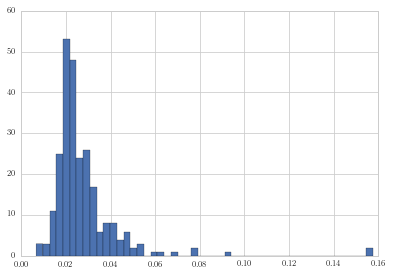

In [451]:
print "# of up-opened", np.sum(peak_y_cst<=0)
print "# of peak < max", np.sum(peak_y_cst<max_y_cst)
plt.hist(peak_y_std_cst, bins=50)
print np.std(peak_y_std_cst), np.mean(peak_y_std_cst)+3*np.std(peak_y_std_cst)
print np.sum(peak_y_std_cst>np.mean(peak_y_std_cst)+3*np.std(peak_y_std_cst))

In [452]:
# start_ind = 0
# # select_ind = np.arange(start_ind, start_ind+10, dtype=int)
# select_ind = np.where(peak_y_cst+3*peak_y_std_cst<max_y_cst)[0][0:3]
# select_max_y = max_y_cst[select_ind]

# print peak_y_std_cst[select_ind]
# print peak_y_cst[select_ind] + 3*peak_y_std_cst[select_ind]
# print max_y_cst[select_ind]

# select_keys = ts_data.index[select_ind]
# # select_ind = np.where(np.in1d(ts_data.index, select_keys))[0]
# for i, k, ymv in zip(select_ind, select_keys, select_max_y):
# # for i, k in zip(invalid_ind, invalid_keys):
#     fig = plt.figure(figsize=(9, 2.5))
#     ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
#     ax2 = plt.subplot2grid((1, 3), (0, 2), colspan=1)

#     y = ts_data.loc[k, :].copy()
#     x = y.index.values
#     y = y.values
#     tmp_ind = np.where(y != no_data)[0]
#     x = x[tmp_ind]
#     y = y[tmp_ind]
#     ax1.plot(x, y, '.r')
#     plt.setp(ax1, title=k, xlabel='DOY', ylabel='NDVI')    
    
#     ts_section = ts_data.loc[k, beg_doy:end_doy].copy()
#     tmp_ind = np.where(ts_section != no_data)[0]
#     y = ts_section.values[tmp_ind]
#     x = ts_section.index.values[tmp_ind]
#     ax2.plot(x, y, '.r')
#     xfit = np.arange(beg_doy, end_doy)
#     ax2.plot(xfit, quad_func[i](xfit), '-b', label="non-constrained")
#     ax2.plot(xfit, quad_func_cst[i](xfit), '-g', label="constrained")
#     ax2.plot([beg_doy, end_doy], [ymv, ymv], '-k')
#     plt.setp(ax2, title=k, xlabel='DOY')
    
#     plt.savefig('../figures/ts_sectional_quad_fit_{0:s}.png'.format(k), dpi=300, bbox_inches='tight', pad_inches=0.)

## Plot crop yield against peak NDVI from quadratic fit

In [453]:
# # select_keys = ['045840-p01']
# # select_ind = np.where(crop_yield_field.index.values == '045840-p01')[0]
# select_ind = np.where(ts_data.max(axis=1)<0.8)[0]
# select_keys = ts_data.index[select_ind]

# print peak_y[select_ind], crop_yield_field.loc[select_keys, 'yield_field']
# for i, k in zip(select_ind, select_keys):   
#     fig = plt.figure(figsize=(9, 2.5))
#     ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
#     ax2 = plt.subplot2grid((1, 3), (0, 2), colspan=1)

#     y = ts_data.loc[k, :]
#     x = y.index.values
#     y = y.values
#     tmp_ind = np.where(y != no_data)[0]
#     x = x[tmp_ind]
#     y = y[tmp_ind]
#     ax1.plot(x, y, '.r')
#     plt.setp(ax1, title=k, xlabel='DOY', ylabel='NDVI')    
    
#     ts_section = ts_data.loc[k, beg_doy:end_doy]
#     tmp_ind = np.where(ts_section != no_data)[0]
#     y = ts_section.values[tmp_ind]
#     x = ts_section.index.values[tmp_ind]
#     ax2.plot(x, y, '.r')
#     xfit = np.arange(beg_doy-10, end_doy)
#     ax2.plot(xfit, quad_func[i](xfit), '-b', label="non-constrained")
#     ax2.plot(xfit, quad_func_cst[i](xfit), '-g', label="constrained")
#     plt.setp(ax2, title=k, xlabel='DOY')    

In [454]:
def expFunc(x, a, b, c):
    # y = a*exp(b*x) + c
    return a * np.exp(b*x) + c

def linFunc(x, a, b):
    # y = a * x + b
    return a * x + b

def fitLinODR(x, y, x_std=None, y_std=None):
    model4odr = spodr.polynomial(1)
    model4odr_func = lambda beta, x: beta[0] + beta[1] * x
    data4odr = spodr.Data(x, y, 
                          we=None if x_std is None else x_std**2, 
                          wd=None if y_std is None else y_std**2)
    odrfit = spodr.ODR(data4odr, model4odr, maxit=10000)
    odrfit_out = odrfit.run()
    pearsonr = sp.stats.pearsonr(x, y)
    r2 = pearsonr[0]**2
    xfit = np.array([np.min(x), np.max(x)])
    yfit = model4odr_func(odrfit_out.beta, xfit)
    return odrfit_out.beta, r2, xfit, yfit

def fitLinOLS(x, y, x_std=None, y_std=None):
    model_func = linFunc
    try:
        coef, pcov = sp.optimize.curve_fit(model_func, x, y, method="trf", max_nfev=1000)
        r2 = 1 - np.sum((y - model_func(x, *coef))**2)/np.sum((y - np.mean(y))**2)
        xfit = np.array([np.min(x), np.max(x)])
        yfit = model_func(xfit, *coef)
    except RuntimeError as e:
        if str(e).find("Optimal parameters not found: ") == -1:
            raise e
        else:
            print "Optimal parameters not found", str(model_func)
            coef = None
            r2 = None
            xfit = None
            yfit = None
    return coef, r2, xfit, yfit

def fitExpOLS(x, y, x_std=None, y_std=None):
    model_func = expFunc
    try:
        coef, pcov = sp.optimize.curve_fit(model_func, x, y, method="trf", max_nfev=1000)
        r2 = 1 - np.sum((y - model_func(x, *coef))**2)/np.sum((y - np.mean(y))**2)
        xfit = np.array([np.min(x), np.max(x)])
        yfit = model_func(xfit, *coef)
    except RuntimeError as e:
        if str(e).find("Optimal parameters not found: ") == -1:
            raise e
        else:
            print "Optimal parameters not found", str(model_func)
            coef = None
            r2 = None
            xfit = None
            yfit = None
    return coef, r2, xfit, yfit

134
69
Model parameters:  [ 4767.06384625  -298.95111266] <function fitLinOLS at 0x2ac806cc8c08>
R-square:  0.147893154922
220
97
Weirdo keys ['004622-p04' '016659-p04' '031939-p01' '031939-p04' '032266-p12'
 '045114-p33' '052026-p01' '068333-p05']
Model parameters:  [ 5042.052889    -517.72631774] <function fitLinOLS at 0x2ac806cc8c08>
R-square:  0.245538773013


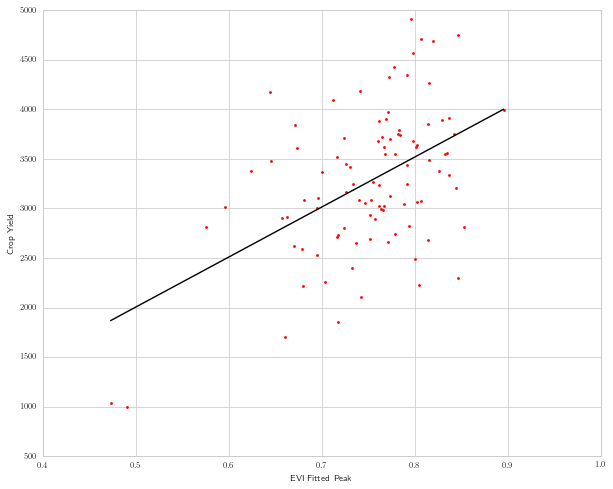

In [492]:
use_plotly = False
# Constrained quad fitting
valid_flag = reduce(np.logical_and, (np.squeeze(peak_x_cst.values)>beg_doy, np.squeeze(peak_x_cst.values)<end_doy, crop_pix_flag, 
                                     np.squeeze(peak_y_cst+2*peak_y_std_cst>max_y_cst)))
# valid_flag = reduce(np.logical_and, (peak_x_cst>beg_doy, peak_x_cst<end_doy, crop_pix_flag, 
#                                      np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02']))))
valid_ind = np.where(valid_flag)[0]
valid_keys = ts_data.index.values[valid_ind]
print np.sum(crop_pix_flag)
print len(valid_keys)

x = peak_y_cst.loc[valid_keys, 0].values
y = crop_yield_field.loc[valid_keys, 'yield_field'].values

# fitting approach
# fit_func = fitLinODR
fit_func = fitLinOLS
# fit_func = fitExpOLS

coef, r2, xfit, yfit = fit_func(x, y, y_std=peak_y_std_cst.loc[valid_keys, 0].values)
if coef is None:
    print "Fitting failed", str(fit_func)
else:
    print "Model parameters: ", coef, str(fit_func)
    print "R-square: ", r2      
        
# tmp_ind = np.where(reduce(np.logical_and, (x>0.75, x<0.8, y>3500)))[0]
# print "weirdos: ", valid_keys[tmp_ind]
# tmp_ind = np.where(x>0.95)[0]
# print "weirdos: ", valid_keys[tmp_ind]

# single_valid_flag = reduce(np.logical_and, (peak_x_cst>beg_doy, peak_x_cst<end_doy, peak_y_cst>=max_y_cst, single_crop_pix_flag))
# single_valid_flag = reduce(np.logical_and, (np.squeeze(peak_x_cst.values)>beg_doy, np.squeeze(peak_x_cst.values)<end_doy, single_crop_pix_flag, 
#                                             np.squeeze(peak_y_cst+2*peak_y_std_cst>max_y_cst)))
single_valid_flag = reduce(np.logical_and, (np.squeeze(peak_x_cst.values)>beg_doy, np.squeeze(peak_x_cst.values)<end_doy, single_crop_pix_flag,
                                            np.squeeze(peak_y_cst+2*peak_y_std_cst>max_y_cst), 
                                            np.logical_not(np.in1d(ts_data.index, ['072557-p10', '072557-p04', '072557-p13', '072557-p02']))))
single_valid_ind = np.where(single_valid_flag)[0]
single_valid_keys = ts_data.index.values[single_valid_ind]
print np.sum(single_crop_pix_flag)
print len(single_valid_keys)

x = peak_y_cst.loc[single_valid_keys, 0].values
y = crop_yield_field.loc[single_valid_keys, 'yield_field'].values

# select points for diagnosis
select_ind = np.where(reduce(np.logical_and, (x<0.72, x>0.5, y<4400, y>3300)))[0]
select_keys = single_valid_keys[select_ind]
print "Weirdo keys", select_keys

coef, r2, single_xfit, single_yfit = fit_func(x, y, y_std=peak_y_std_cst.loc[single_valid_keys, 0].values)
if coef is None:
    print "Fitting failed", str(fit_func)
else:
    print "Model parameters: ", coef, str(fit_func)
    print "R-square: ", r2 

fig, ax = plt.subplots(figsize=(10, 8))
if use_plotly:
    ax.plot(peak_y_cst.loc[single_valid_keys, 0], crop_yield_field.loc[single_valid_keys, 'yield_field'], '.r', label='pixel of subplot is crop')
else:
    ax.plot(peak_y_cst.loc[single_valid_keys, 0], crop_yield_field.loc[single_valid_keys, 'yield_field'], '.r', label='pixel of subplot is crop')
#     ax.errorbar(peak_y_cst.loc[single_valid_keys, 0], crop_yield_field.loc[single_valid_keys, 'yield_field'], 
#             xerr=peak_y_std_cst.loc[single_valid_keys, 0], fmt='.r', label='pixel of subplot is crop')

# ax.plot(peak_y_cst.loc[valid_keys, 0], crop_yield_field.loc[valid_keys, 'yield_field'], '.g', label='pixels of 3-by-3 window are all crop')# 
if single_yfit is not None:
    ax.plot(single_xfit, single_yfit, '-k')
# if yfit is not None:
#     ax.plot(xfit, yfit, '-g')
plt.setp(ax, xlim=(0.4, 1), xlabel='EVI Fitted Peak', ylabel='Crop Yield')
if use_plotly:
    plotly_fig = plotly.tools.mpl_to_plotly(fig)
    plotly_fig['layout']['showlegend'] = True
    plotly_fig['layout']['legend'] = dict(orientation="h")
    plotly_fig['data'][0]['text'] = single_valid_keys
    plotly_fig['data'][1]['text'] = valid_keys
    iplot(plotly_fig)
else:
#     ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
    plt.savefig('../figures/reg_ndvi_vs_yield_ts_quadfit_constrained.png', dpi=300, bbox_inches='tight', pad_inches=0.)

## Output results to CSV for ADB

In [488]:
out_df4adb = crop_yield_field.copy()

out_df4adb.loc[:, 'crop_pixel_flag'] = pd.Series(np.zeros(len(out_df4adb), dtype=np.bool), index=out_df4adb.index)
out_df4adb.loc[peak_y_cst.index, 'crop_pixel_flag'] = single_crop_pix_flag

out_df4adb.loc[:, 'select_for_reg_flag'] = pd.Series(np.zeros(len(out_df4adb), dtype=np.bool), index=out_df4adb.index)
out_df4adb.loc[single_valid_keys, 'select_for_reg_flag'] = True

out_df4adb.loc[:, 'fit_peak_evi'] = pd.Series(np.zeros(len(out_df4adb))+np.nan, index=out_df4adb.index)
out_df4adb.loc[peak_y_cst.index, 'fit_peak_evi'] = peak_y_cst.loc[:, 0]

out_df4adb.loc[:, 'fit_peak_std_evi'] = pd.Series(np.zeros(len(out_df4adb))+np.nan, index=out_df4adb.index)
out_df4adb.loc[peak_y_std_cst.index, 'fit_peak_std_evi'] = peak_y_std_cst.loc[:, 0]

out_df4adb = out_df4adb.rename(index=str, columns={'lat_m':'lat_mesh', 'lon_m':'lon_mesh', 'lat_s':'lat_subplot', 'lon_s':'lon_subplot'})
# write to csv
out_df4adb.to_csv("../results/thai_binh_crop_fit_peak_vi.csv")

In [304]:
print peak_y_cst.loc['050656-p04'], crop_yield_field.loc['050656-p04', :], peak_y_std_cst.loc['050656-p04']

0    0.716716
Name: 050656-p04, dtype: float64 mesh_id          50656
plot_id            p04
lat_m          20.4258
lon_m          106.571
lat_s          20.4259
lon_s          106.571
variety           DT68
yield_field    3828.22
Name: 050656-p04, dtype: object 0    0.022367
Name: 050656-p04, dtype: float64


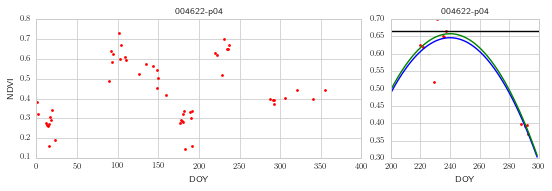

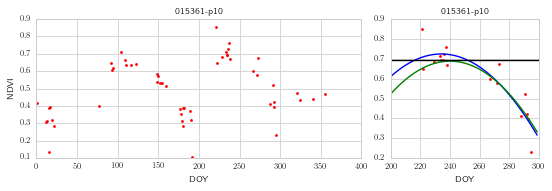

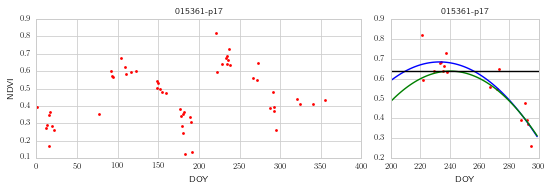

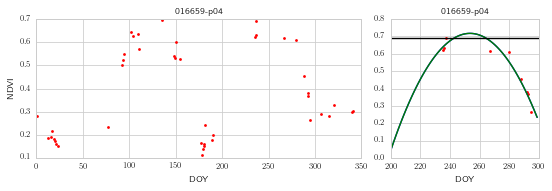

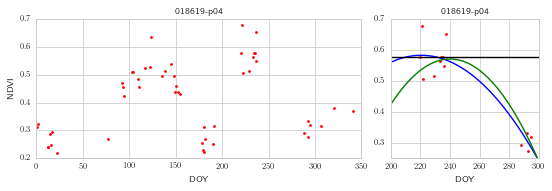

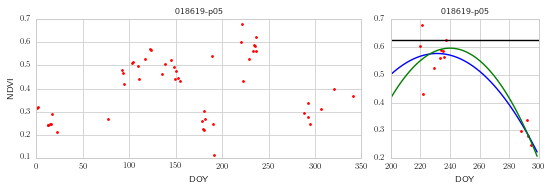

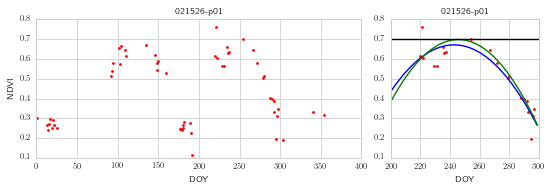

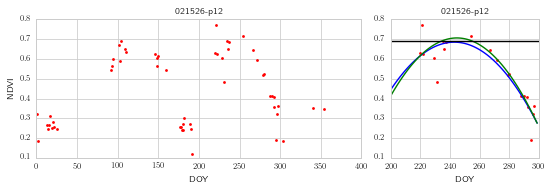

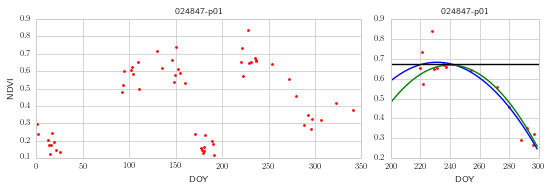

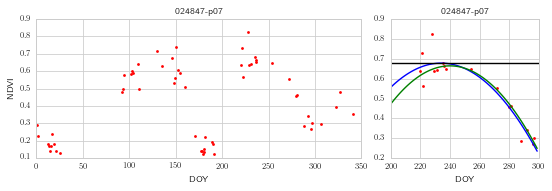

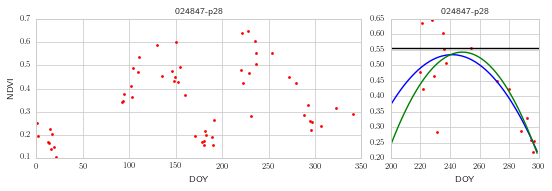

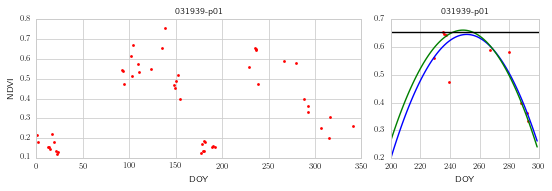

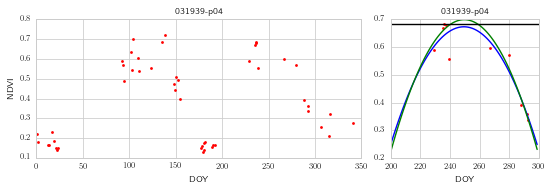

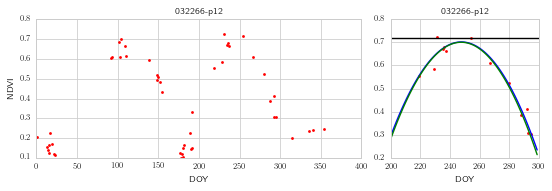

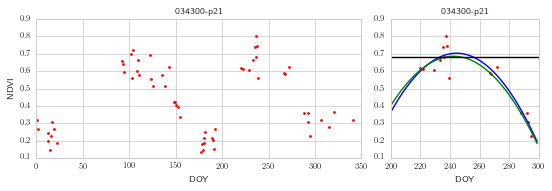

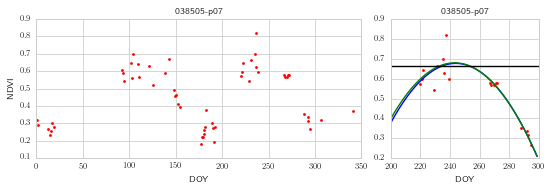

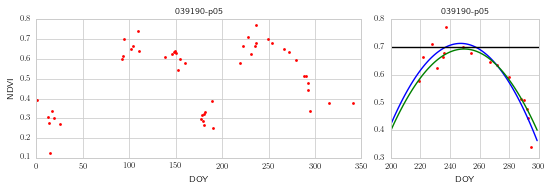

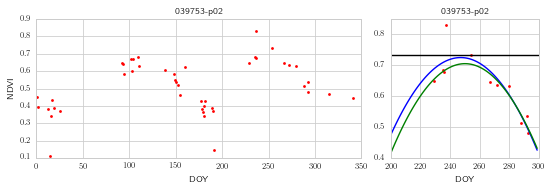

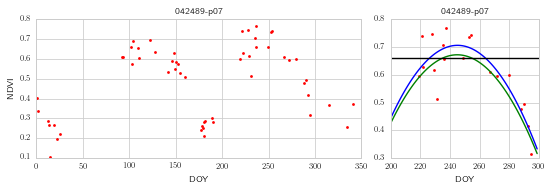

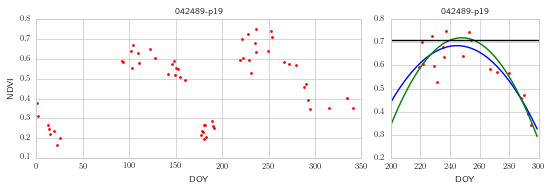

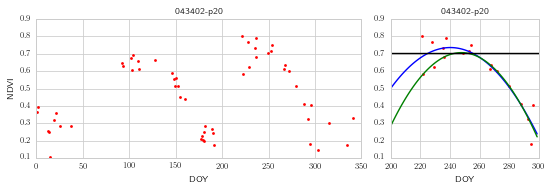

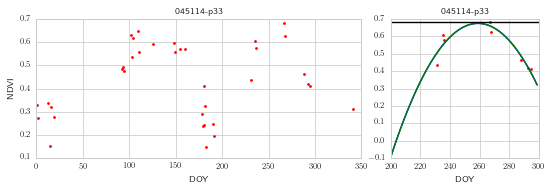

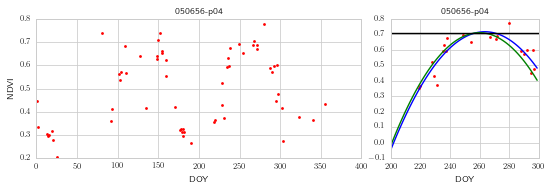

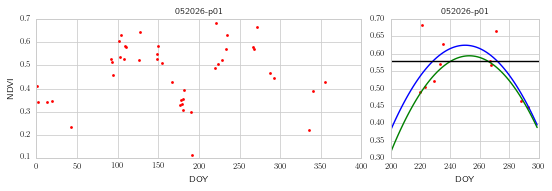

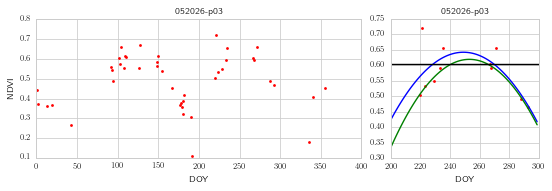

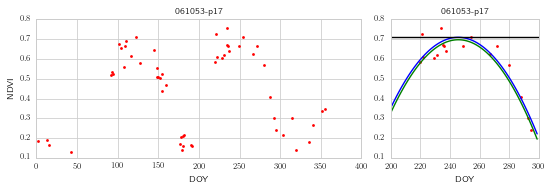

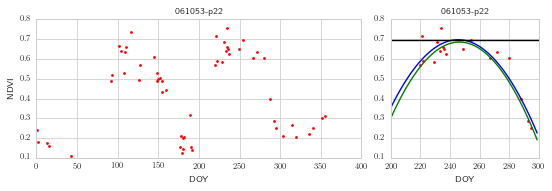

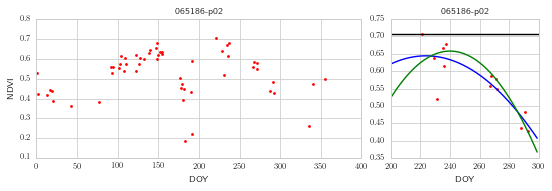

In [90]:
# examine the time series of the found weirdos 
# select_keys = ['065186-p06', '015361-p17', '034300-p21']
# select_keys = ['072557-p10', '072557-p04', '072557-p13', '072557-p02']
select_ind = np.where(np.in1d(ts_data.index, select_keys))[0]
select_max_y = max_y_cst.loc[select_keys, 0]

# print peak_y_std_cst[select_ind]
# print peak_y_cst[select_ind] + 3*peak_y_std_cst[select_ind]
# print max_y_cst[select_ind]

for i, k, ymv in zip(select_ind, select_keys, select_max_y):
# for i, k in zip(invalid_ind, invalid_keys):
    fig = plt.figure(figsize=(9, 2.5))
    ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((1, 3), (0, 2), colspan=1)

    y = ts_data.loc[k, :].copy()
    x = y.index.values
    y = y.values
    tmp_ind = np.where(y != no_data)[0]
    x = x[tmp_ind]
    y = y[tmp_ind]
    ax1.plot(x, y, '.r')
    plt.setp(ax1, title=k, xlabel='DOY', ylabel='NDVI')    
    
    ts_section = ts_data.loc[k, beg_doy:end_doy].copy()
    tmp_ind = np.where(ts_section != no_data)[0]
    y = ts_section.values[tmp_ind]
    x = ts_section.index.values[tmp_ind]
    ax2.plot(x, y, '.r')
    xfit = np.arange(beg_doy, end_doy)
    ax2.plot(xfit, quad_func[i](xfit), '-b', label="non-constrained")
    ax2.plot(xfit, quad_func_cst[i](xfit), '-g', label="constrained")
    ax2.plot([beg_doy, end_doy], [ymv, ymv], '-k')
    plt.setp(ax2, title=k, xlabel='DOY')
    
#     print y

In [134]:
y.shape

(95,)

In [140]:
use_plotly = True
# Simple stats, e.g maximum, mean or median, from given temporal window
beg_doy = 240
end_doy = 260
valid_flag = crop_pix_flag
valid_ind = np.where(valid_flag)[0]
valid_keys = ts_data.index.values[valid_ind]
print np.sum(crop_pix_flag)
# print len(valid_keys)

tmp = ts_data.loc[valid_keys, beg_doy:end_doy].copy().values
tmp[tmp==no_data] = np.nan
x = np.nanmean(tmp, axis=1)
tmp_flag = np.logical_not(np.isnan(x))
x = x[tmp_flag]
valid_x = x
y = crop_yield_field.loc[valid_keys, 'yield_field'].values[tmp_flag]
valid_y = y


# fitting approach
# fit_func = fitLinODR
fit_func = fitLinOLS

coef, r2, xfit, yfit = fit_func(x, y)
if coef is None:
    print "Fitting failed", str(fit_func)
else:
    print "Model parameters: ", coef, str(fit_func)
    print "R-square: ", r2

tmp_ind = np.where(x<0.75)[0]
print "weirdos: ", valid_keys[tmp_ind]

single_valid_flag = single_crop_pix_flag
single_valid_ind = np.where(single_valid_flag)[0]
single_valid_keys = ts_data.index.values[single_valid_ind]
print np.sum(single_crop_pix_flag)
# print len(single_valid_keys)

tmp = ts_data.loc[single_valid_keys, beg_doy:end_doy].copy().values
tmp[tmp==no_data] = np.nan
x = np.nanmean(tmp, axis=1)
tmp_flag = np.logical_not(np.isnan(x))
x = x[tmp_flag]
single_valid_x = x
y = crop_yield_field.loc[single_valid_keys, 'yield_field'].values[tmp_flag]
single_valid_y = y

coef, r2, single_xfit, single_yfit = fit_func(x, y)
if coef is None:
    print "Fitting failed", str(fit_func)
else:
    print "Model parameters: ", coef, str(fit_func)
    print "R-square: ", r2

fig, ax = plt.subplots()
ax.plot(single_valid_x, single_valid_y, '.r', label='pixel of subplot is crop')
ax.plot(valid_x, valid_y, '.g', label='pixels of 3-by-3 window are all crop')# 
if single_yfit is not None:
    ax.plot(single_xfit, single_yfit, '-r')
if yfit is not None:
    ax.plot(xfit, yfit, '-g')
plt.setp(ax, xlim=(0., 1), ylim=(0, 6000))
plt.setp(ax, xlabel='NDVI peak', ylabel='Crop yield', 
         title="simple maximum between {0:d} to {1:d}".format(beg_doy, end_doy))
if use_plotly:
    plotly_fig = plotly.tools.mpl_to_plotly(fig)
    plotly_fig['layout']['showlegend'] = True
    plotly_fig['layout']['legend'] = dict(orientation="h")
#     plotly_fig['data'][0]['text'] = single_valid_keys
#     plotly_fig['data'][1]['text'] = valid_keys
    iplot(plotly_fig)
else:
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
    plt.savefig('../figures/reg_ndvi_vs_yield_simple_stats.png', dpi=300, bbox_inches='tight', pad_inches=0.)

134
Model parameters:  [ 2038.21193256  1698.62948697] <function fitLinOLS at 0x2ac838520a28>
R-square:  0.0545397972888
weirdos:  ['011504-p05' '015361-p10' '015625-p14' '015625-p18' '017127-p12'
 '017745-p01' '017745-p15' '017850-p02' '017850-p13' '018042-p07'
 '018151-p12' '018619-p02' '020190-p05' '020258-p06' '020258-p12'
 '020258-p15' '020292-p03' '020292-p04' '020861-p06' '020861-p10'
 '020861-p16' '021776-p08' '021776-p15' '021776-p19' '022965-p08'
 '022965-p17' '022965-p22' '024019-p01' '024019-p02' '024019-p04'
 '024047-p03']
220
Model parameters:  [-1034.41023397  3887.31874751] <function fitLinOLS at 0x2ac838520a28>
R-square:  0.0333335393382


134
19
count    19.000000
mean     11.421053
std       1.426565
min       9.000000
25%      10.500000
50%      11.000000
75%      12.500000
max      14.000000
dtype: float64
count    236.000000
mean      15.567797
std        3.597822
min        8.000000
25%       13.000000
50%       15.000000
75%       18.000000
max       24.000000
dtype: float64
0.00417215843278
[-1193.8709705   4498.22523164] <function linFunc at 0x2ac836237de8>
220
30
0.0445274594799
[ 2717.91547843  1284.73048856] <function linFunc at 0x2ac836237de8>


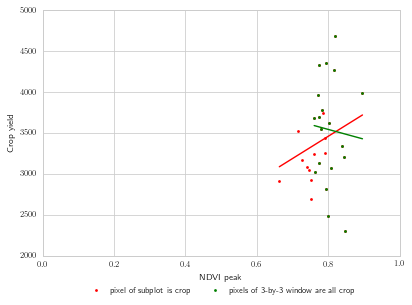

In [92]:
# Non-constrained quad fitting, with both extra fitting filtering and spatial filtering
valid_flag = reduce(np.logical_and, (peak_x>beg_doy, peak_x<end_doy, peak_y>=max_y, crop_pix_flag))
valid_ind = np.where(valid_flag)[0]
valid_keys = ts_data.index.values[valid_ind]
print np.sum(crop_pix_flag)
print len(valid_keys)
# number of valid TS values for these selected subplots
print np.sum(ts_data.loc[valid_keys, beg_doy:end_doy]!=no_data, axis=1).describe()
print np.sum(ts_data.loc[ts_data.index.values[np.where(np.logical_not(valid_flag))[0]], beg_doy:end_doy]!=no_data, axis=1).describe()

x = peak_y[valid_ind]
y = crop_yield_field.loc[valid_keys, 'yield_field'].values

# linear model
model_func = linFunc
# exponential model
# model_func = expFunc
try:
    coef, pcov = sp.optimize.curve_fit(model_func, x, y, method="trf", max_nfev=1000)
    r2 = 1 - np.sum((y - model_func(x, *coef))**2)/np.sum((y - np.mean(y))**2)
    print r2
    print coef, str(model_func)
    xfit = np.array([np.min(x), np.max(x)])
    yfit = model_func(xfit, *coef)
except RuntimeError as e:
    if str(e).find("Optimal parameters not found: ") == -1:
        raise e
    else:
        print "Optimal parameters not found", str(model_func)
        xfit = None
        yfit = None

single_valid_flag = reduce(np.logical_and, (peak_x>beg_doy, peak_x<end_doy, peak_y>=max_y, single_crop_pix_flag))
single_valid_ind = np.where(single_valid_flag)[0]
single_valid_keys = ts_data.index.values[single_valid_ind]
print np.sum(single_crop_pix_flag)
print len(single_valid_keys)

x = peak_y[single_valid_ind]
y = crop_yield_field.loc[single_valid_keys, 'yield_field'].values

try:
    coef, pcov = sp.optimize.curve_fit(model_func, x, y, method="trf", max_nfev=1000)
    r2 = 1 - np.sum((y - model_func(x, *coef))**2)/np.sum((y - np.mean(y))**2)
    print r2
    print coef, str(model_func)
    single_xfit = np.array([np.min(x), np.max(x)])
    single_yfit = model_func(single_xfit, *coef)
except RuntimeError as e:
    if str(e).find("Optimal parameters not found: ") == -1:
        raise e
    else:
        print "Optimal parameters not found", str(model_func)
        single_xfit = None
        single_yfit = None

fig, ax = plt.subplots()
ax.plot(peak_y[single_valid_ind], crop_yield_field.loc[single_valid_keys, 'yield_field'], '.r', label='pixel of subplot is crop')
ax.plot(peak_y[valid_ind], crop_yield_field.loc[valid_keys, 'yield_field'], '.g', label='pixels of 3-by-3 window are all crop')# 
if single_yfit is not None:
    ax.plot(single_xfit, single_yfit, '-r')
if yfit is not None:
    ax.plot(xfit, yfit, '-g')
plt.setp(ax, xlim=(0., 1))
# ax.set_title('NDVI fuse Terra + Landsat Obs., Quadratic fitting to TS section from 220 to 300, Pure crop pixel')
plt.setp(ax, xlabel='NDVI peak', ylabel='Crop yield')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.savefig('../figures/reg_ndvi_vs_yield_ts_quadfit_nonconstrained.png', dpi=300, bbox_inches='tight', pad_inches=0.)

In [93]:
# Non-constrainted quad fitting, only spatial filtering
valid_flag = reduce(np.logical_and, (crop_pix_flag, peak_y>0.1))
valid_ind = np.where(valid_flag)[0]
valid_keys = ts_data.index.values[valid_ind]
print np.sum(crop_pix_flag)
print len(valid_keys)

x = peak_y[valid_ind]
y = crop_yield_field.loc[valid_keys, 'yield_field'].values
coef = np.polyfit(x, y, 1)
reg_func = np.poly1d(coef)

r2 = 1 - np.sum((y - reg_func(x))**2)/np.sum((y - np.mean(y))**2)
print r2
print coef, "coef[0]*x+coef[1]"

xfit = np.array([np.min(x), np.max(x)])
yfit = reg_func(xfit)

single_valid_flag = reduce(np.logical_and, (single_crop_pix_flag, peak_y>0.1))
single_valid_ind = np.where(single_valid_flag)[0]
single_valid_keys = ts_data.index.values[single_valid_ind]
print np.sum(single_crop_pix_flag)
print len(single_valid_keys)

x = peak_y[single_valid_ind]
y = crop_yield_field.loc[single_valid_keys, 'yield_field'].values
coef = np.polyfit(x, y, 1)
reg_func = np.poly1d(coef)

r2 = 1 - np.sum((y - reg_func(x))**2)/np.sum((y - np.mean(y))**2)
print r2
print coef, "coef[0]*x+coef[1]"

single_xfit = np.array([np.min(x), np.max(x)])
single_yfit = reg_func(single_xfit)

fig, ax = plt.subplots()
ax.plot(peak_y[single_valid_ind], crop_yield_field.loc[single_valid_keys, 'yield_field'], '.r', label='pixel of subplot is crop')
ax.plot(peak_y[valid_ind], crop_yield_field.loc[valid_keys, 'yield_field'], '.g', label='pixels of 3-by-3 window are all crop')# 
ax.plot(single_xfit, single_yfit, '-r')
ax.plot(xfit, yfit, '-g')
plt.setp(ax, xlim=(0., 1))
# ax.set_title('NDVI fuse Terra + Landsat Obs., Quadratic fitting to TS section from 220 to 300, Pure crop pixel')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.setp(ax, xlabel='NDVI peak', ylabel='Crop yield')
plt.savefig('../figures/reg_ndvi_vs_yield_no_tsfilter.png', dpi=300, bbox_inches='tight', pad_inches=0.)

134
133
0.0265848719
[ 1864.41889894  1850.7184253 ] coef[0]*x+coef[1]
220
217
0.0122861576424
[  901.82541674  2596.14585142] coef[0]*x+coef[1]


In [94]:
select_flag = [k.find('031939')>-1 for k in ts_data.index.values]
select_ind = np.where(select_flag)[0]
select_keys = ts_data.index[select_ind]
print select_ind, select_keys
print np.in1d(select_keys, valid_keys)

[143 144 145 146] Index([u'031939-p01', u'031939-p02', u'031939-p03', u'031939-p04'], dtype='object', name=u'full_id')
[False False False False]


## Plot NDVI SG fit peak against cropy yield

In [95]:
del ts_data
ts_data = ts_ndvi_sg.copy()

In [96]:
valid_flag = reduce(np.logical_and, ((ts_data!=no_data).all(axis=1), crop_pix_flag))
valid_ind = np.where(valid_flag)[0]
valid_keys = ts_data.index.values[valid_ind]
print len(valid_keys)

x = ts_data.loc[valid_keys, 200:300].copy().max(axis=1)
y = crop_yield_field.loc[valid_keys, 'yield_field'].values
coef = np.polyfit(x, y, 1)
reg_func = np.poly1d(coef)
yfit = reg_func(x)
r2 = 1 - np.sum((y - yfit)**2)/np.sum((y - np.mean(y))**2)
print r2

122
0.0455991709696


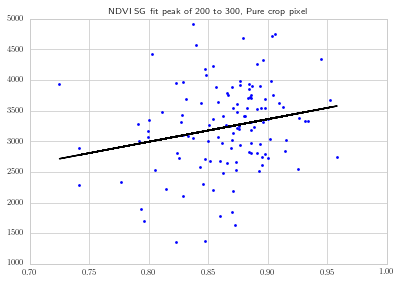

In [97]:
fig, ax = plt.subplots()
ax.plot(x, y, '.b')
ax.plot(x, yfit, '-k')
plt.setp(ax, xlim=(0.7, 1))
ax.set_title('NDVI SG fit peak of 200 to 300, Pure crop pixel')
plt.savefig('../figures/reg_ndvi_vs_yield.png', dpi=300, bbox_inches='tight', pad_inches=0.)

## Plot ALOS data

In [98]:
del ts_data
ts_data = ts_alos_hh.copy()

134
134
220
220


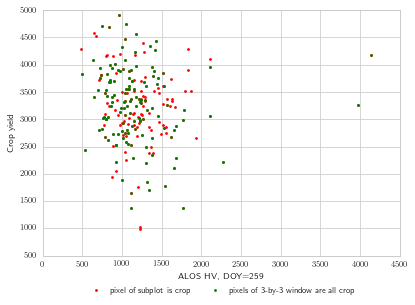

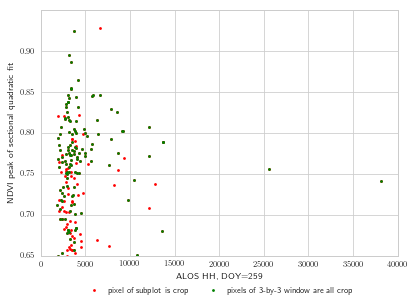

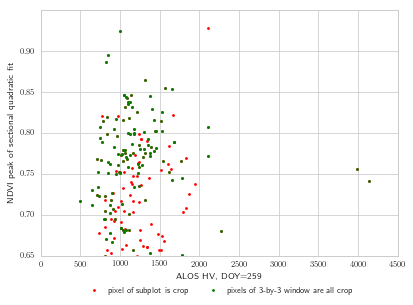

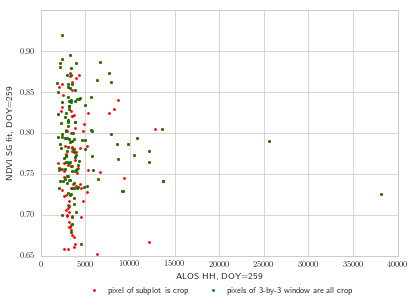

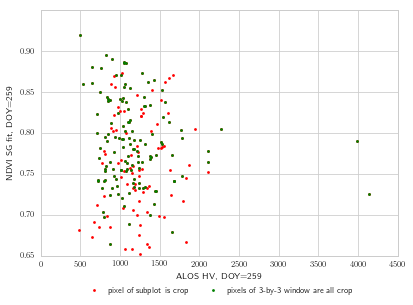

In [99]:
# ALOS v.s. NDVI

doy = 259

valid_flag = crop_pix_flag
valid_ind = np.where(valid_flag)[0]
valid_keys = ts_data.index.values[valid_ind]
print np.sum(crop_pix_flag)
print len(valid_keys)

single_valid_flag = single_crop_pix_flag
single_valid_ind = np.where(single_valid_flag)[0]
single_valid_keys = ts_data.index.values[single_valid_ind]
print np.sum(single_crop_pix_flag)
print len(single_valid_keys)

fig, ax = plt.subplots()
ax.plot(ts_alos_hh.loc[single_valid_keys, doy], crop_yield_field.loc[single_valid_keys, 'yield_field'], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hh.loc[valid_keys, doy], crop_yield_field.loc[valid_keys, 'yield_field'], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HH, DOY={0:d}'.format(doy), ylabel='Crop yield')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.savefig('../figures/reg_alos_hh_vs_yield.png', dpi=300, bbox_inches='tight', pad_inches=0.)

fig, ax = plt.subplots()
ax.plot(ts_alos_hv.loc[single_valid_keys, doy], crop_yield_field.loc[single_valid_keys, 'yield_field'], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hv.loc[valid_keys, doy], crop_yield_field.loc[valid_keys, 'yield_field'], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HV, DOY={0:d}'.format(doy), ylabel='Crop yield')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.savefig('../figures/reg_alos_hv_vs_yield.png', dpi=300, bbox_inches='tight', pad_inches=0.)

fig, ax = plt.subplots()
ax.plot(ts_alos_hh.loc[single_valid_keys, doy], peak_y[single_valid_ind], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hh.loc[valid_keys, doy], peak_y[valid_ind], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HH, DOY={0:d}'.format(doy), ylabel='NDVI peak of sectional quadratic fit', ylim=(0.65, 0.95))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.savefig('../figures/reg_alos_hh_vs_ndvi_quad_peak.png', dpi=300, bbox_inches='tight', pad_inches=0.)

fig, ax = plt.subplots()
ax.plot(ts_alos_hv.loc[single_valid_keys, doy], peak_y[single_valid_ind], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hv.loc[valid_keys, doy], peak_y[valid_ind], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HV, DOY={0:d}'.format(doy), ylabel='NDVI peak of sectional quadratic fit', ylim=(0.65, 0.95))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.savefig('../figures/reg_alos_hv_vs_ndvi_quad_peak.png', dpi=300, bbox_inches='tight', pad_inches=0.)


fig, ax = plt.subplots()
ax.plot(ts_alos_hh.loc[single_valid_keys, doy], ts_ndvi_sg.loc[single_valid_keys, doy], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hh.loc[valid_keys, doy], ts_ndvi_sg.loc[valid_keys, doy], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HH, DOY={0:d}'.format(doy), ylabel='NDVI SG fit, DOY={0:d}'.format(doy), ylim=(0.65, 0.95))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.savefig('../figures/reg_alos_hh_vs_ndvi_sg.png', dpi=300, bbox_inches='tight', pad_inches=0.)

fig, ax = plt.subplots()
ax.plot(ts_alos_hv.loc[single_valid_keys, doy], ts_ndvi_sg.loc[single_valid_keys, doy], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hv.loc[valid_keys, doy], ts_ndvi_sg.loc[valid_keys, doy], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HV, DOY={0:d}'.format(doy), ylabel='NDVI SG fit, DOY={0:d}'.format(doy), ylim=(0.65, 0.95))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.savefig('../figures/reg_alos_hv_vs_ndvi_sg.png', dpi=300, bbox_inches='tight', pad_inches=0.)

In [100]:
del ts_data
ts_data = ts_alos_hh.copy()

134
19
220
30


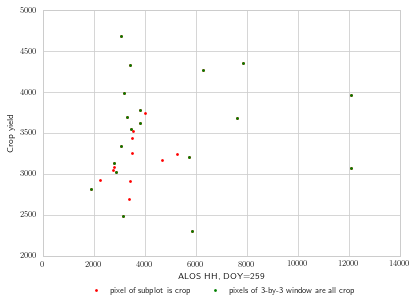

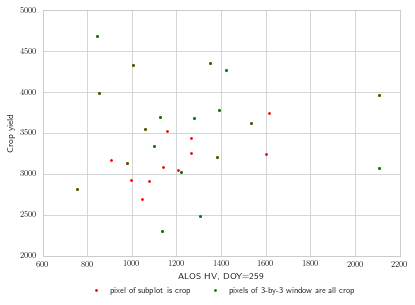

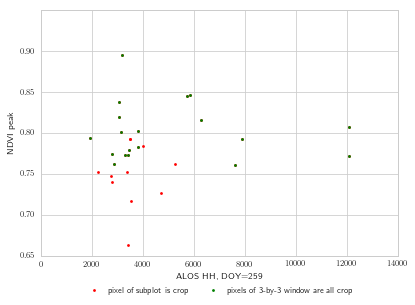

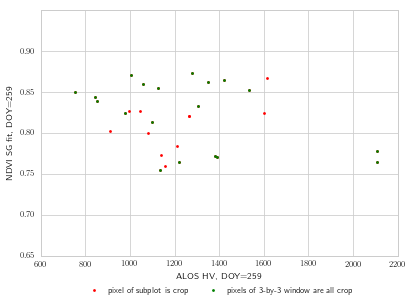

In [101]:
# ALOS v.s. Crop yield

doy = 259

valid_flag = reduce(np.logical_and, (peak_x>beg_doy, peak_x<end_doy, peak_y>=max_y, crop_pix_flag))
valid_ind = np.where(valid_flag)[0]
valid_keys = ts_data.index.values[valid_ind]
print np.sum(crop_pix_flag)
print len(valid_keys)

single_valid_flag = reduce(np.logical_and, (peak_x>beg_doy, peak_x<end_doy, peak_y>=max_y, single_crop_pix_flag))
single_valid_ind = np.where(single_valid_flag)[0]
single_valid_keys = ts_data.index.values[single_valid_ind]
print np.sum(single_crop_pix_flag)
print len(single_valid_keys)

fig, ax = plt.subplots()
ax.plot(ts_alos_hh.loc[single_valid_keys, doy], crop_yield_field.loc[single_valid_keys, 'yield_field'], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hh.loc[valid_keys, doy], crop_yield_field.loc[valid_keys, 'yield_field'], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HH, DOY={0:d}'.format(doy), ylabel='Crop yield')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

fig, ax = plt.subplots()
ax.plot(ts_alos_hv.loc[single_valid_keys, doy], crop_yield_field.loc[single_valid_keys, 'yield_field'], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hv.loc[valid_keys, doy], crop_yield_field.loc[valid_keys, 'yield_field'], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HV, DOY={0:d}'.format(doy), ylabel='Crop yield')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

fig, ax = plt.subplots()
ax.plot(ts_alos_hh.loc[single_valid_keys, doy], peak_y[single_valid_ind], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hh.loc[valid_keys, doy], peak_y[valid_ind], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HH, DOY={0:d}'.format(doy), ylabel='NDVI peak', ylim=(0.65, 0.95))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

fig, ax = plt.subplots()
ax.plot(ts_alos_hv.loc[single_valid_keys, doy], peak_y[single_valid_ind], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hv.loc[valid_keys, doy], peak_y[valid_ind], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HV, DOY={0:d}'.format(doy), ylabel='NDVI peak', ylim=(0.65, 0.95))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)


fig, ax = plt.subplots()
ax.plot(ts_alos_hh.loc[single_valid_keys, doy], ts_ndvi_sg.loc[single_valid_keys, doy], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hh.loc[valid_keys, doy], ts_ndvi_sg.loc[valid_keys, doy], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HH, DOY={0:d}'.format(doy), ylabel='NDVI SG fit, DOY={0:d}'.format(doy), ylim=(0.65, 0.95))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

fig, ax = plt.subplots()
ax.plot(ts_alos_hv.loc[single_valid_keys, doy], ts_ndvi_sg.loc[single_valid_keys, doy], '.r', label='pixel of subplot is crop')
ax.plot(ts_alos_hv.loc[valid_keys, doy], ts_ndvi_sg.loc[valid_keys, doy], '.g', label='pixels of 3-by-3 window are all crop')
plt.setp(ax, xlabel='ALOS HV, DOY={0:d}'.format(doy), ylabel='NDVI SG fit, DOY={0:d}'.format(doy), ylim=(0.65, 0.95))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)